<a id='back_to_top'></a>

# Sections


* [1. Build subj data structure](#data_struct)
* [2. Define functions](#def_functs)
* [3. Examples](#exs)
    * 3.1 [RF angle maps](#ang_maps)
    * 3.2 [RF eccentricity maps](#rf_ecc)
    * 3.3 [Mean functional data - NSD img](#mean_nsdimg)



In [30]:
import cortex
import nibabel 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import glob

%matplotlib inline

In [31]:
mpl.rcParams['figure.dpi']= 15

In [32]:
save_path = '/home/breedlov/SDB/nsd_results/flatmaps/'
data_path = '/home/breedlov/SDB/nsd_results/'

subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08'] #option of not using all subjects
data_list = ['val_cc', 'rf_ang', 'rf_ecc', 'rf_size', 'mean_nsdimagery'] #an ex, these are the differnt results that I have for ea subject that I want to put on a flatmap

timestr = time.strftime("%Y%m%d") #-%H%M"


<a id='data_struct'></a>

## BUILD SUBJECT DATA STRUCTURE

Build a dictionary that points to all the relevant result/data niftis (by searching for niftis with strings from [data_list] in their name) and all relevant pycortex transforms.

It assumes the following file structure in [data_path]
* subjXX/
    * anat0pt8/
        * [any results/data in 0.8 anatomical space]
    * func1pt8/
        * [any results/data in 1.8 functional space]
    * func1pt0/
        * [any results/data in 1.0 functional space]



In [33]:
pyctx_dict = {}

pyctx_dict['xforms'] = {}
pyctx_dict['xforms']['func1pt0'] = 'func1pt0_to_anat0pt8_autoFSbbr' # change these if you make diff xforms you prefer
pyctx_dict['xforms']['func1pt8'] = 'func1pt8_to_anat0pt8_autoFSbbr'
pyctx_dict['xforms']['anat0pt8'] = 'identity'

for subj in subj_list:
    print ("\n\n****************  %s VOLUMES ****************" %(subj))
    pyctx_dict[subj] = {}    
    pyctx_dict[subj]['func1pt8'] = {}
    pyctx_dict[subj]['func1pt0'] = {}
    pyctx_dict[subj]['anat0pt8'] = {}
    
    for k in pyctx_dict[subj].keys():
    
        for d in data_list:

            file_name = f'{data_path}{subj}/{k}/*{d}*.nii*'
            f = glob.glob(file_name)
            if f==[]:
                print (f'WARNING: no *{d}* data file for {subj} in {k} space')
            elif len(f) > 1:
                print (f'WARNING: multiple *{d}* data files for {subj} in {k} space, not adding anything to dict')
            else:
                print (f[0])
                pyctx_dict[subj][k][d] = f[0]
        print()
                



****************  subj01 VOLUMES ****************
/home/breedlov/SDB/nsd_results/subj01/func1pt8/val_cc_Feb-05-2020_1609.nii
/home/breedlov/SDB/nsd_results/subj01/func1pt8/rf_ang_Feb-05-2020_1609.nii
/home/breedlov/SDB/nsd_results/subj01/func1pt8/rf_ecc_Feb-05-2020_1609.nii
/home/breedlov/SDB/nsd_results/subj01/func1pt8/rf_size_Feb-05-2020_1609.nii


/home/breedlov/SDB/nsd_results/subj01/anat0pt8/val_cc_Feb-05-2020_1609_in_anat0pt8_nearest.nii
/home/breedlov/SDB/nsd_results/subj01/anat0pt8/rf_ang_Feb-05-2020_1609_in_anat0pt8_nearest.nii
/home/breedlov/SDB/nsd_results/subj01/anat0pt8/rf_ecc_Feb-05-2020_1609_in_anat0pt8_nearest.nii
/home/breedlov/SDB/nsd_results/subj01/anat0pt8/rf_size_Feb-05-2020_1609_in_anat0pt8_nearest.nii
/home/breedlov/SDB/nsd_results/subj01/anat0pt8/mean_nsdimagery_in_anat0pt8_nearest.nii



****************  subj02 VOLUMES ****************
/home/breedlov/SDB/nsd_results/subj02/func1pt8/val_cc_Feb-07-2020_2237.nii
/home/breedlov/SDB/nsd_results/subj02/func1pt8/rf

<a id='def_functs'></a>

## DEFINE FUNCTIONS


[back to top](#back_to_top)

In [34]:
def make_flatmap_figs(subj, data, dataspace, data2=None, cmap='jet', vmin=0, vmax=1, vmin2=0, vmax2=1, 
                           with_colorbar=False, surf_type='sulci', save_pic=True, dpi=600, bgcolor=None, 
                           show_image=True):
    
    if data in pyctx_dict[subj][dataspace]:
        
        # select appropriate xform for given dataspace
        pc_xform = pyctx_dict['xforms'][dataspace]
        
        # load primary data
        d =nibabel.load(pyctx_dict[subj][dataspace][data])  
        d = d.get_fdata().T.astype(float)      
        if pc_xform=='identity':
            d = np.flip((np.rot90(d, k=3)),2) # identity isn't quite true, data that aligns to the subj anatomical must first be tipped forward 90deg then flipped left/right
        
        # load secondary data if it was passed
        if data2 is not None:
            
            d2 =nibabel.load(pyctx_dict[subj][dataspace][data2])  
            d2 = d2.get_fdata().T.astype(float) 
            if pc_xform=='identity':
                d2 = np.flip((np.rot90(d2, k=3)),2)          
        
        # build the pycortex volume
            vol_data = cortex.Volume2D(d, d2, subj, pc_xform, cmap=cmap, 
                                       vmin=vmin, vmax=vmax, vmin2=vmin2, vmax2=vmax2)    
        else:
            vol_data = cortex.Volume(d, subj, pc_xform, 
                               cmap=cmap, 
                               vmin=vmin, 
                               vmax=vmax) 
        
        # set parameters for selected texture/color of the cortical surface
        curv_contrast = None if surf_type == 'sulci' else 0
        curv_bright = None if surf_type == 'sulci' else 0 if surf_type == 'black' else 1 if surf_type == 'white' else .5
        
        # make the figure; there are many more arguments that can be tweaked than what is shown here
        fig = cortex.quickflat.make_figure(vol_data, 
                                  recache=False, 
                                  pixelwise=True,
                                  thick=1,
                                  sampler='nearest', 
                                  height=2048,
                                  depth=.5,
                                  with_rois=False, 
                                  with_labels=False, 
                                  with_colorbar=with_colorbar,  
                                  with_dropout=False, 
                                  with_curvature=True,  
                                  curvature_brightness=curv_bright, 
                                  curvature_contrast=curv_contrast, 
                                  curvature_threshold=None, 
                                  colorbar_location=(.39, .95, .2, .04))
        # showing inline
        if show_image:
            plt.show()
        
        # saving 
        if save_pic:
            filename = "%s_%s_flatmap_%s_%s_%.2fto%.2f" %(subj, data, dataspace, cmap, vmin, vmax)
            filename = save_path + filename.replace('.', 'pt') + '.png'
            print (filename)

            imsize = fig.get_axes()[0].get_images()[0].get_size()
            fig.set_size_inches(np.array(imsize)[::-1] / float(dpi))
            if bgcolor is None:
                fig.savefig(filename, transparent=True, dpi=dpi)
            else:
                fig.savefig(filename, facecolor=bgcolor, transparent=False, dpi=dpi)
        fig.clf()
        plt.close()
        
    else:
        print ('%s does not exist for %s' %(data, subj))


<a id='exs'></a>

# EXAMPLES



<a id='ang_maps'></a>

## Angle


[back to top](#back_to_top)



****************  subj01  ****************


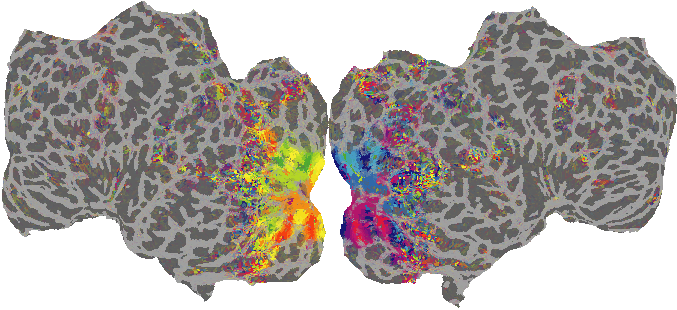

/home/breedlov/SDB/nsd_results/flatmaps/subj01_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj02  ****************


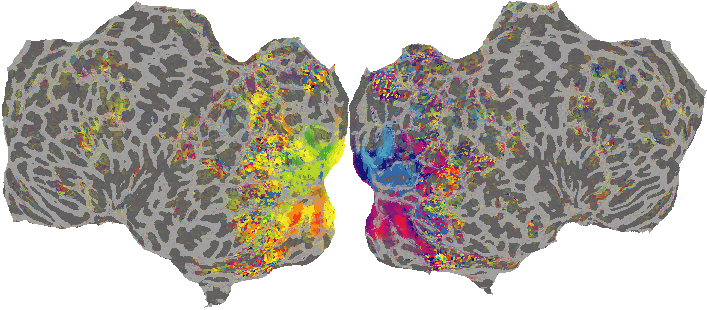

/home/breedlov/SDB/nsd_results/flatmaps/subj02_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj03  ****************


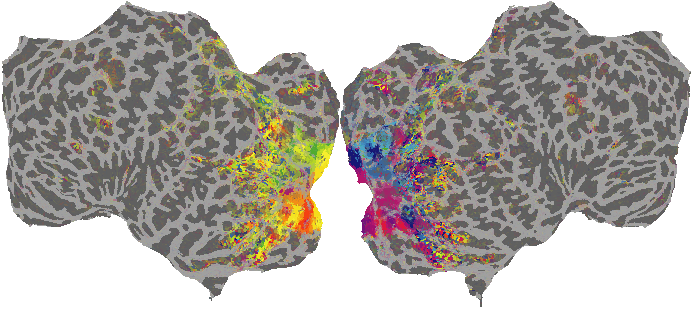

/home/breedlov/SDB/nsd_results/flatmaps/subj03_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj04  ****************


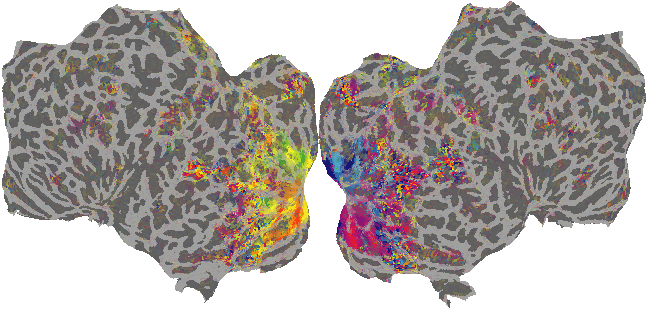

/home/breedlov/SDB/nsd_results/flatmaps/subj04_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj05  ****************


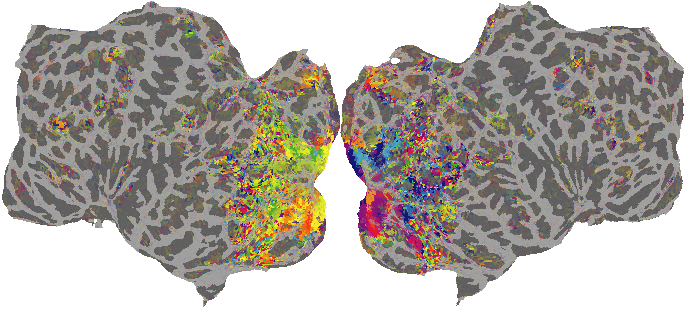

/home/breedlov/SDB/nsd_results/flatmaps/subj05_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj06  ****************


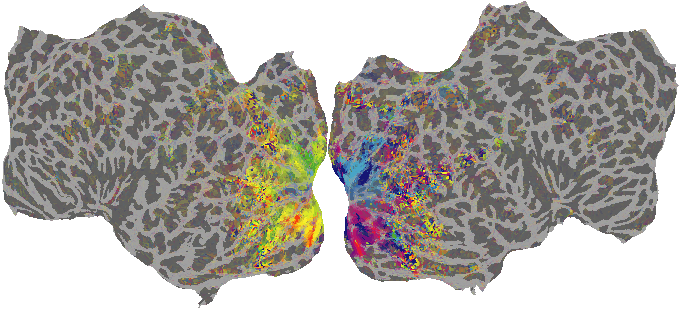

/home/breedlov/SDB/nsd_results/flatmaps/subj06_rf_ang_flatmap_anat0pt8_J4_alpha_2D_-3pt14to3pt14.png


****************  subj07  ****************
rf_ang does not exist for subj07


****************  subj08  ****************
rf_ang does not exist for subj08


In [35]:
## 2D COLORMAPS:  ANGLE MASKED WITH CC

dataspace = 'anat0pt8' #'func1pt0' 'anat0pt8' 'func1pt8'

data = 'rf_ang'
vmin = -np.pi
vmax = np.pi

data2 = 'val_cc'
vmin2 = 0
vmax2 = .4

cmap = 'J4_alpha_2D'

surf_type = 'sulci' # sulci, white, grey, or black
with_colorbar = False
show_image = True
save_pic = True



for subj in subj_list:

    print ("\n\n****************  %s  ****************" %(subj))
    p = make_flatmap_figs(subj, data, dataspace, data2=data2, cmap=cmap, vmin=vmin, vmax=vmax, 
                               vmin2=vmin2, vmax2=vmax2, with_colorbar=with_colorbar, surf_type=surf_type, 
                               save_pic=save_pic, show_image=show_image)
    




<a id='rf_ecc'></a>

## ECC


[back to top](#back_to_top)



****************  subj01  ****************


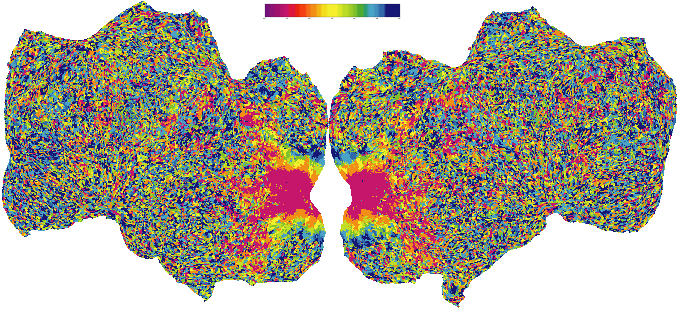

/home/breedlov/SDB/nsd_results/flatmaps/subj01_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj02  ****************


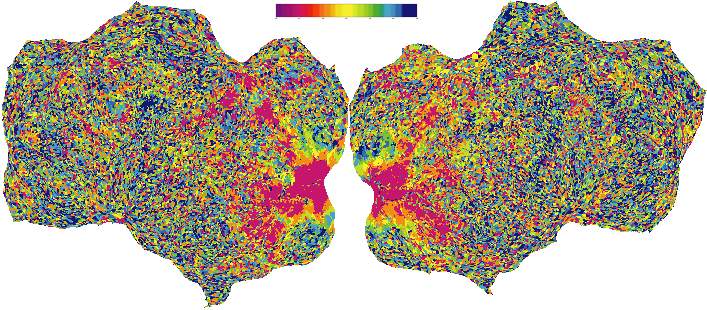

/home/breedlov/SDB/nsd_results/flatmaps/subj02_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj03  ****************


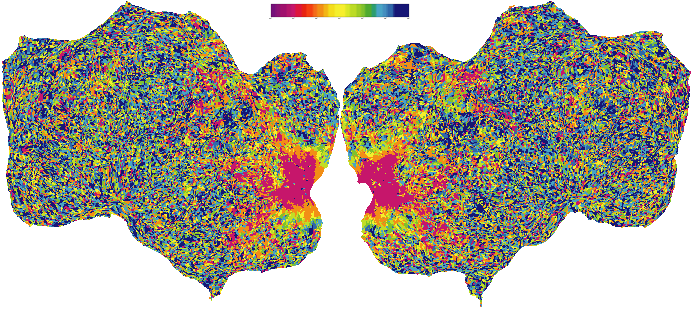

/home/breedlov/SDB/nsd_results/flatmaps/subj03_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj04  ****************


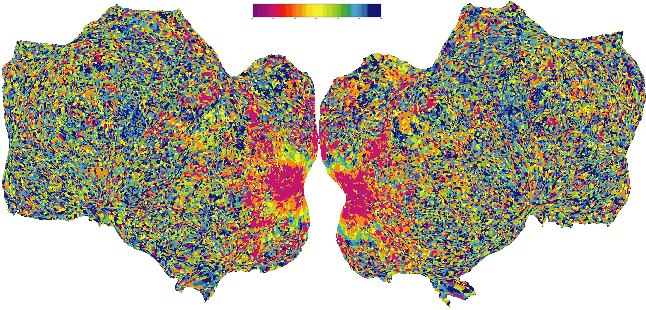

/home/breedlov/SDB/nsd_results/flatmaps/subj04_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj05  ****************


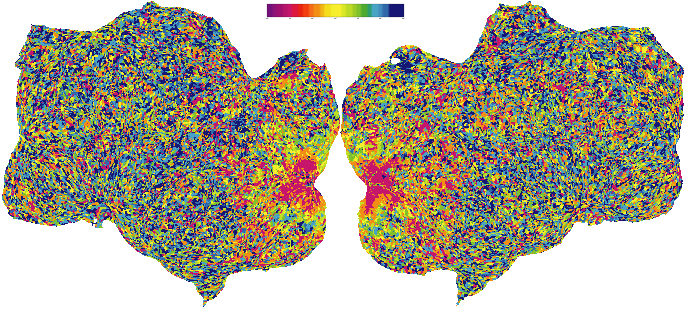

/home/breedlov/SDB/nsd_results/flatmaps/subj05_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj06  ****************


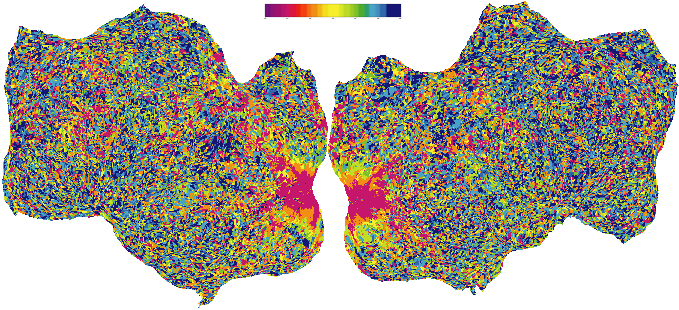

/home/breedlov/SDB/nsd_results/flatmaps/subj06_rf_ecc_flatmap_anat0pt8_J4_r_0pt00to0pt60.png


****************  subj07  ****************
rf_ecc does not exist for subj07


****************  subj08  ****************
rf_ecc does not exist for subj08


In [36]:
## RF ECCENTRICITY 

data = 'rf_ecc'
dataspace = 'anat0pt8' #'func1pt0' 'anat0pt8' 'func1pt8'
cmap = 'J4_r'
vmin = 0
vmax = .6
with_colorbar = True
show_image = True
save_pic = True


for subj in subj_list:

    print ("\n\n****************  %s  ****************" %(subj))
    p = make_flatmap_figs(subj, data, dataspace, cmap=cmap, vmin=vmin, vmax=vmax, with_colorbar=with_colorbar, 
                           save_pic=save_pic)
    

<a id='mean_nsdimg'></a>

## MEAN FUNCTIONAL - NSD IMG


[back to top](#back_to_top)



****************  subj01  ****************


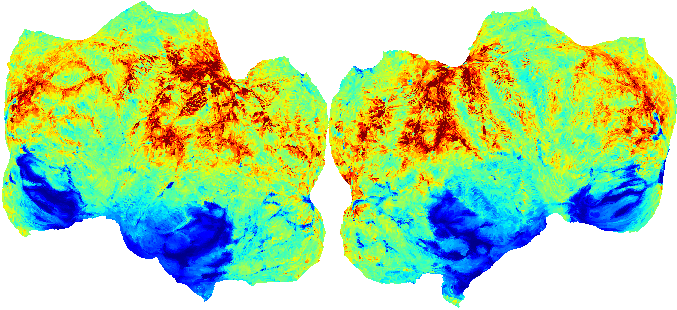

/home/breedlov/SDB/nsd_results/flatmaps/subj01_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj02  ****************


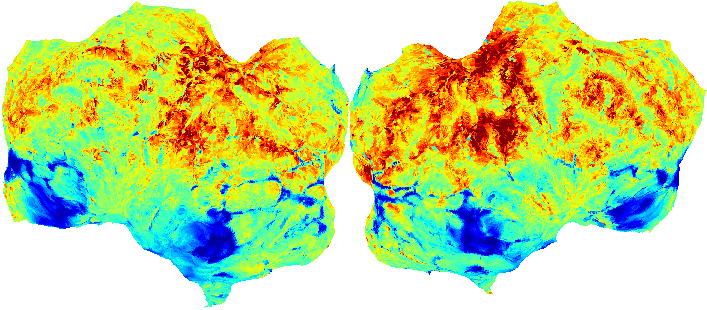

/home/breedlov/SDB/nsd_results/flatmaps/subj02_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj03  ****************


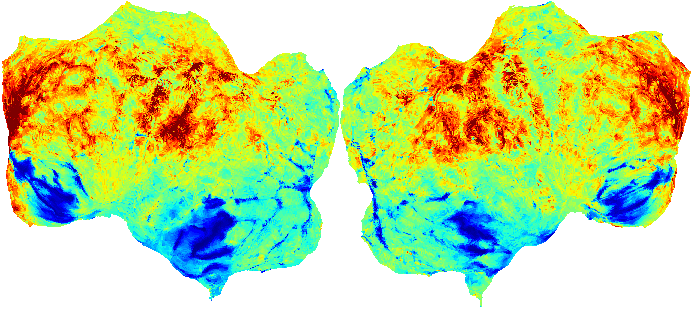

/home/breedlov/SDB/nsd_results/flatmaps/subj03_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj04  ****************


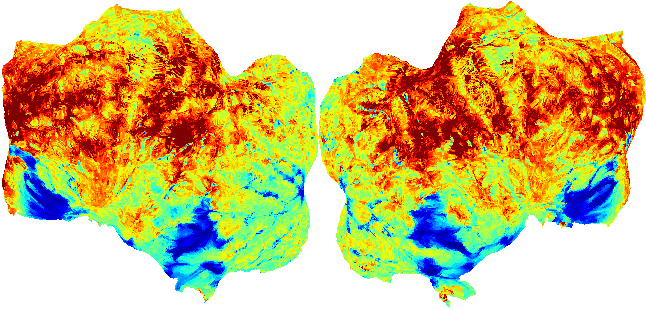

/home/breedlov/SDB/nsd_results/flatmaps/subj04_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj05  ****************


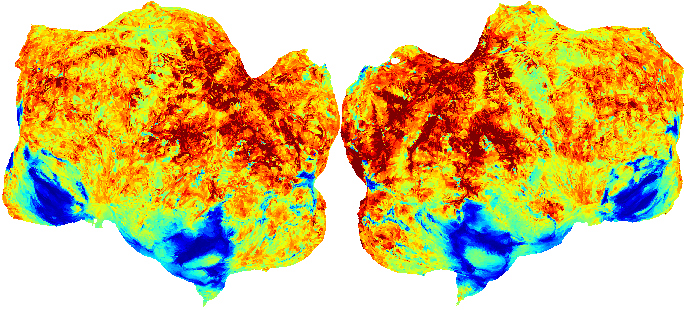

/home/breedlov/SDB/nsd_results/flatmaps/subj05_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj06  ****************


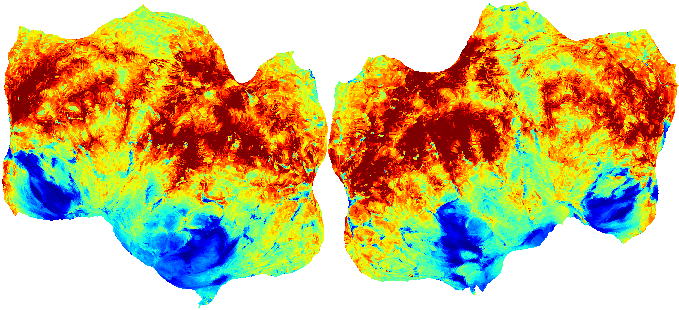

/home/breedlov/SDB/nsd_results/flatmaps/subj06_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj07  ****************


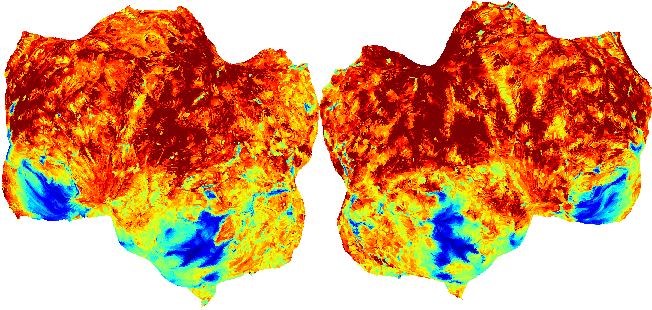

/home/breedlov/SDB/nsd_results/flatmaps/subj07_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


****************  subj08  ****************


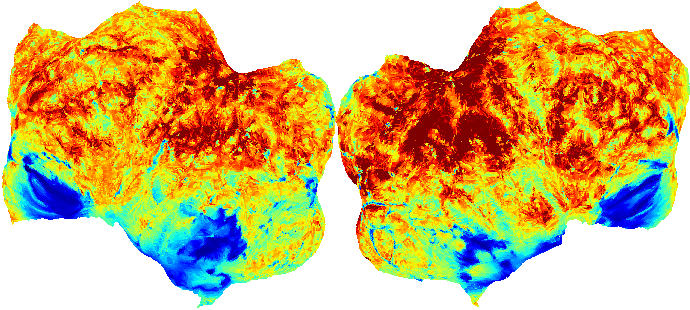

/home/breedlov/SDB/nsd_results/flatmaps/subj08_mean_nsdimagery_flatmap_anat0pt8_jet_0pt00to1000pt00.png


In [37]:
## mean nsd imagery 

data = 'mean_nsdimagery'
dataspace = 'anat0pt8' #'func1pt0' 'anat0pt8' 'func1pt8'
cmap = 'jet'
vmin = 0
vmax = 1000
with_colorbar = False
show_image = True
save_pic = True


for subj in subj_list:

    print ("\n\n****************  %s  ****************" %(subj))
    p = make_flatmap_figs(subj, data, dataspace, cmap=cmap, vmin=vmin, vmax=vmax, with_colorbar=with_colorbar, 
                           save_pic=save_pic, show_image=show_image)
    